In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-08-24 12:18:55


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

from invisible_cities.types.ic_types          import Counter
from invisible_cities.types.ic_types          import NN
from invisible_cities.types.ic_types          import xy
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf
from   invisible_cities.reco import pmaps_functions_c  as cpmp
from   invisible_cities.reco import pmaps_functions  as pmp
from   invisible_cities.reco.xy_algorithms      import corona

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map
from   invisible_cities.icaro.mpl_functions   import draw_pmt_map

In [73]:
from invisible_cities.io.pmap_io import load_pmaps
from invisible_cities.io.hits_io import load_hits
from invisible_cities.io.hits_io import load_hits_skipping_NN

from invisible_cities.io.pmap_io import s1_s2_si_from_pmaps
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si
import invisible_cities.evm.event_model as evm
from invisible_cities.evm.event_model import HitCollection
from invisible_cities.evm.event_model import Hit
from invisible_cities.evm.event_model import Voxel
from invisible_cities.evm.event_model import BHit

from invisible_cities.evm.event_model import Track
from invisible_cities.evm.event_model import Blob
from invisible_cities.evm.event_model import TrackCollection
from invisible_cities.evm.event_model import VoxelCollection

In [5]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmZeroCharge
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound
from invisible_cities.core.exceptions        import ClusterEmptyList
from invisible_cities.core.exceptions        import XYRecoFail

In [6]:
from invisible_cities.icaro.hvt_mpl import draw_voxels
from invisible_cities.icaro.hvt_mpl import draw_voxels2
from invisible_cities.icaro.hvt_mpl import plot_hits_3D
from invisible_cities.icaro.hvt_mpl import draw_tracks
import invisible_cities.icaro.hvt_mpl as hvt

In [7]:
import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.paolina_functions as paf

In [8]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [9]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

### Debug flag

In [10]:
DEB = True

In [11]:
def max_events_reached(nmax, n_events_in):
    if nmax < 0:
        return False
    if n_events_in == nmax:
        print('reached max nof of events (= {})'
                  .format(nmax))
        return True
    return False


### Open file

In [11]:
hits_file_name = os.path.join(os.environ['IC_DATA'], 'NEXT_v1_00_05', 'Tl',
                        'dst_NEXT_v1_00_05_Tl_ACTIVE_100_0_7bar_DST_10.h5')

print('hits_file_name = {}'.format(hits_file_name))

hits_file_name = /Users/jjgomezcadenas/Projects/ICDATA/NEXT_v1_00_05/Tl/dst_NEXT_v1_00_05_Tl_ACTIVE_100_0_7bar_DST_10.h5


In [15]:
hits = load_hits(hits_file_name)

In [22]:
d = 16 * units.mm 
vox_size = np.array([d,d,d],dtype=np.int16)    # voxel size
blob_radius = 25.                    # blob radius in mm
voxel_size = Voxel(d, d, d, 1)

----event = 5000000--- 



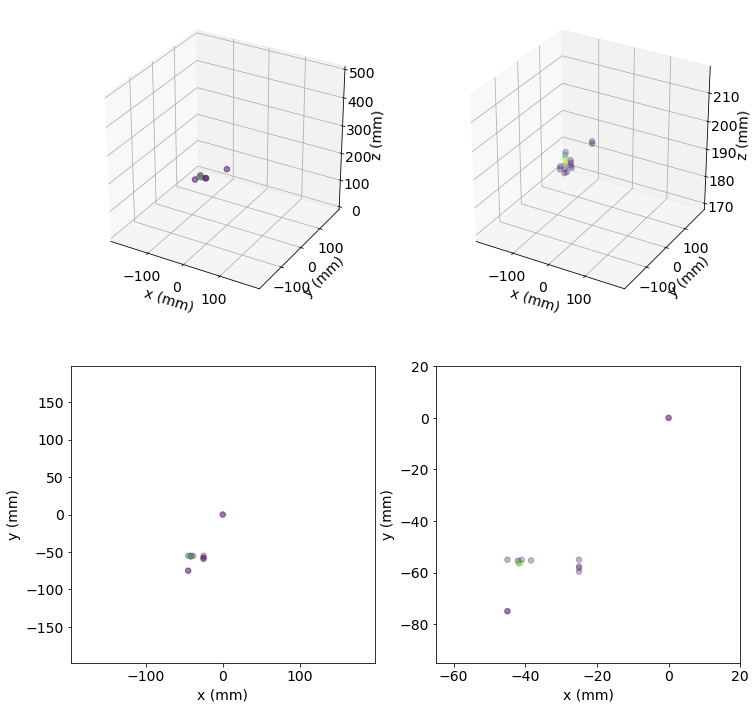

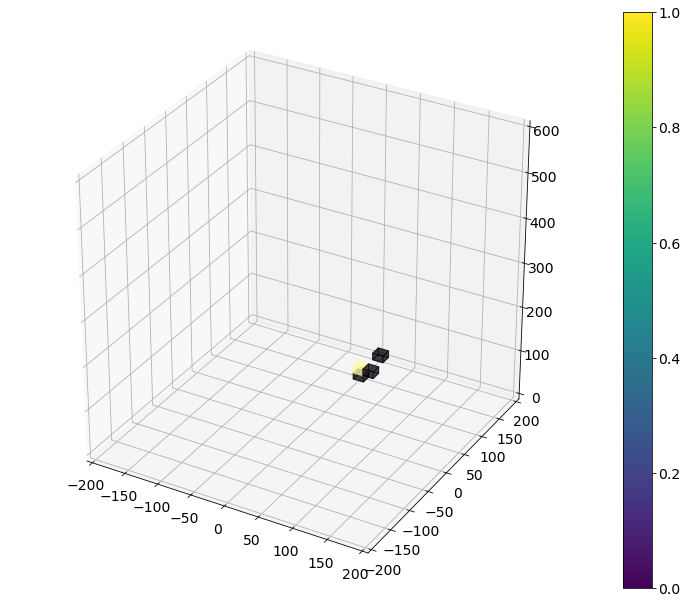

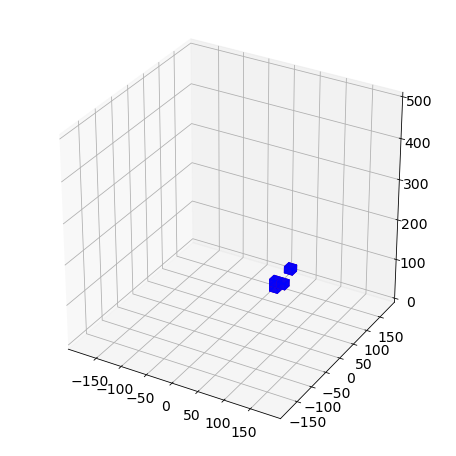

number of tracks found = 2
----event = 5000003--- 



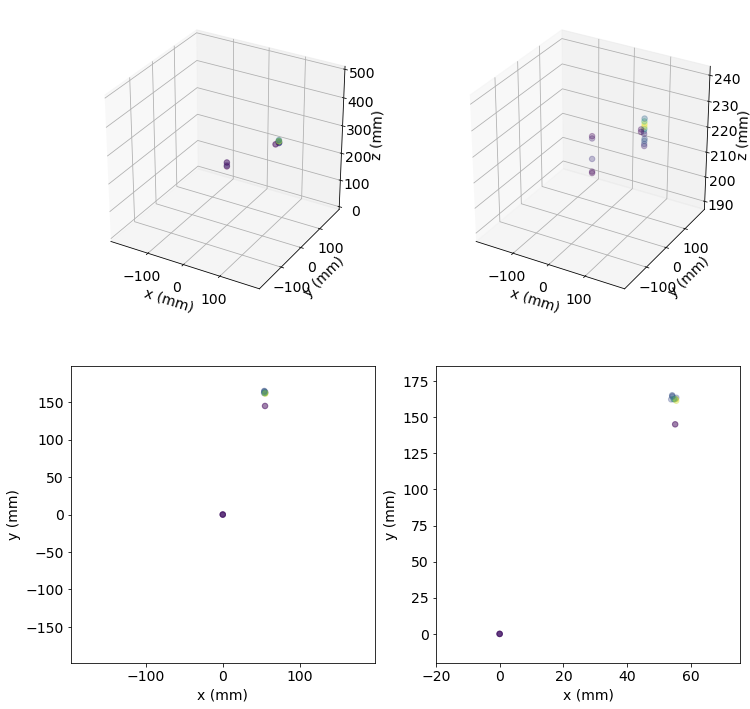

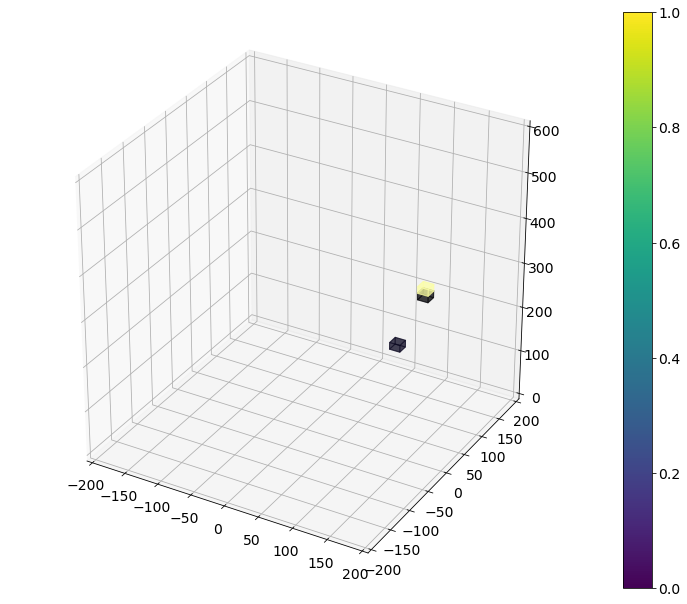

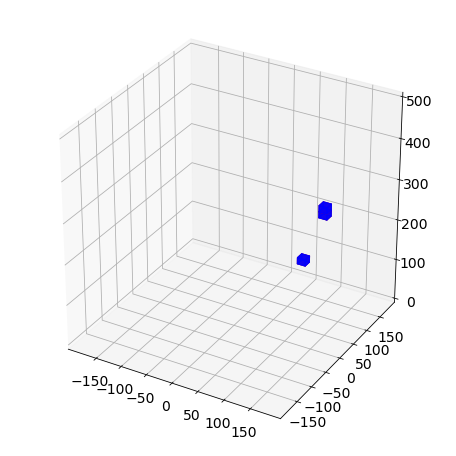

number of tracks found = 2
----event = 5000004--- 



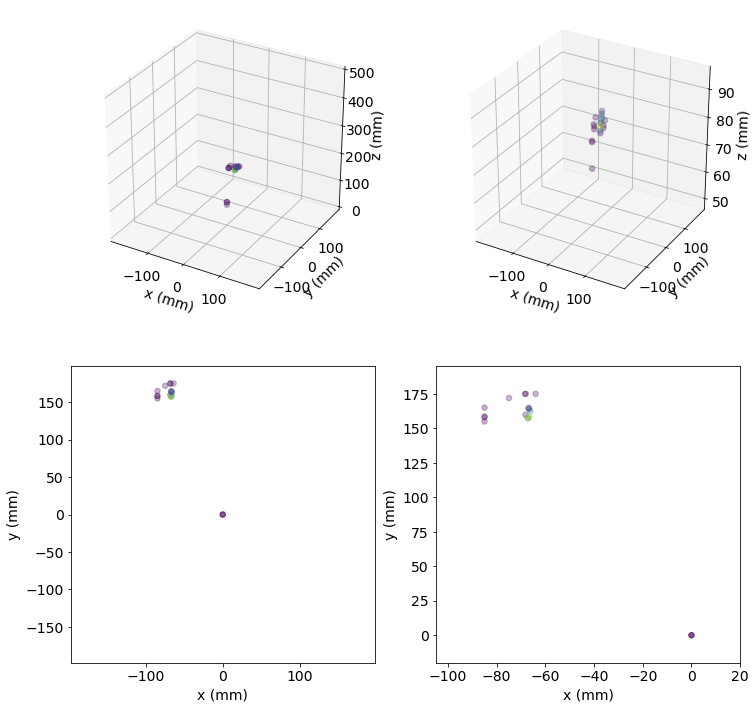

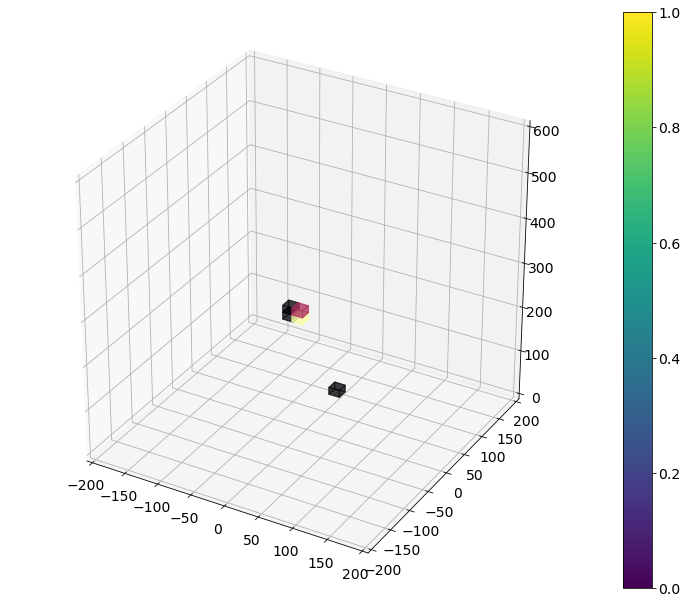

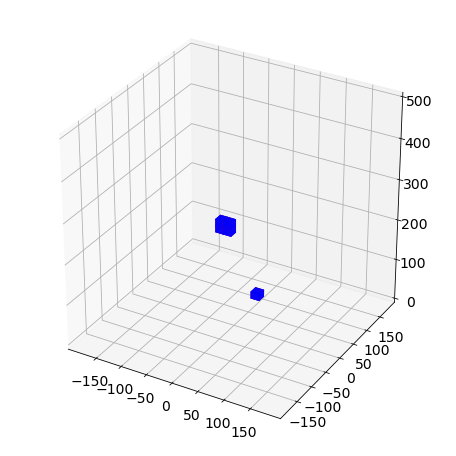

number of tracks found = 2
----event = 5000007--- 



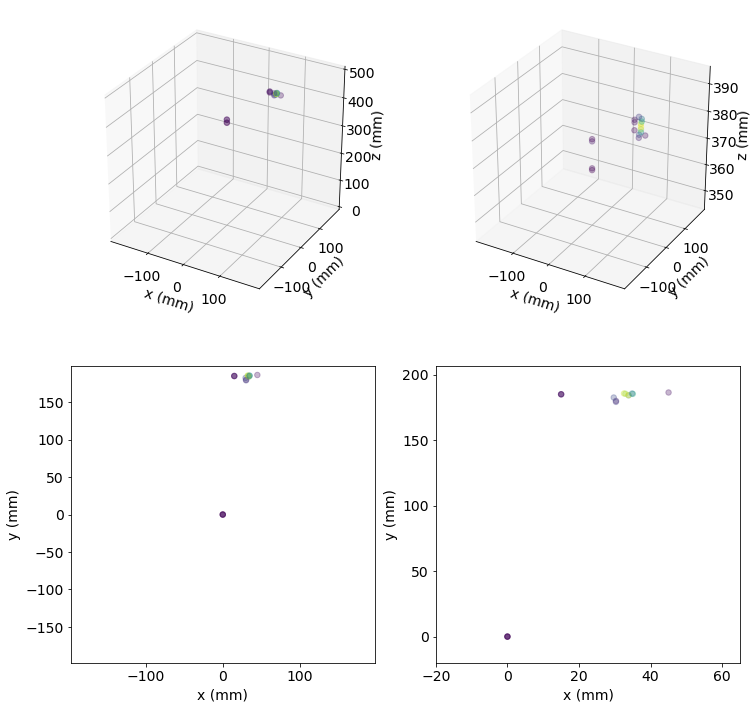

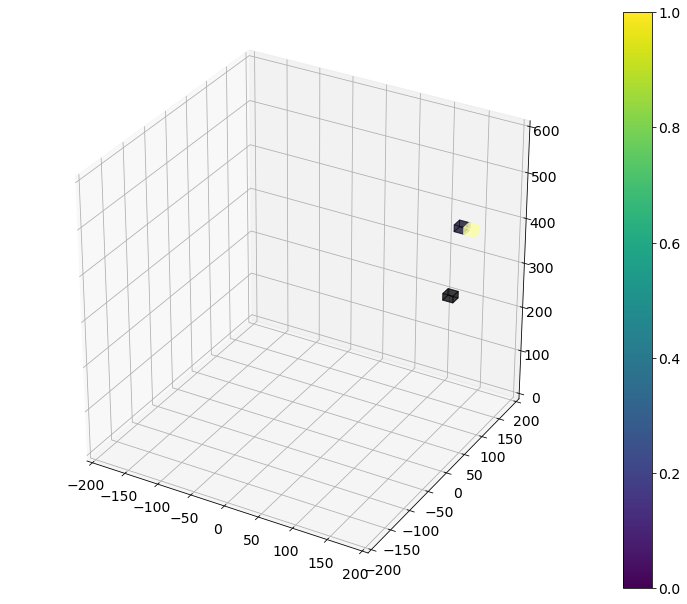

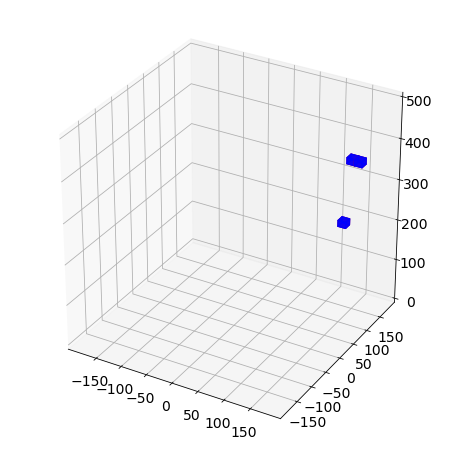

number of tracks found = 2
----event = 5000010--- 



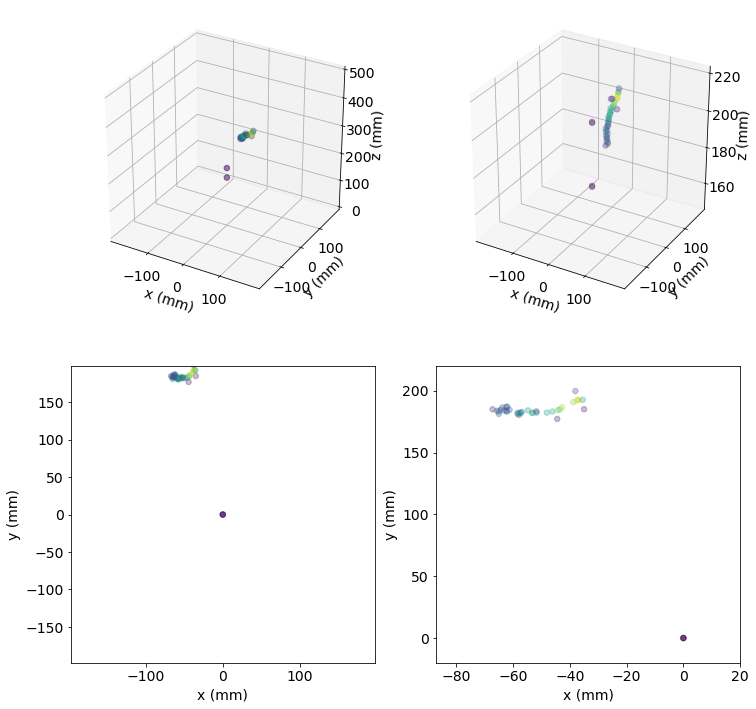

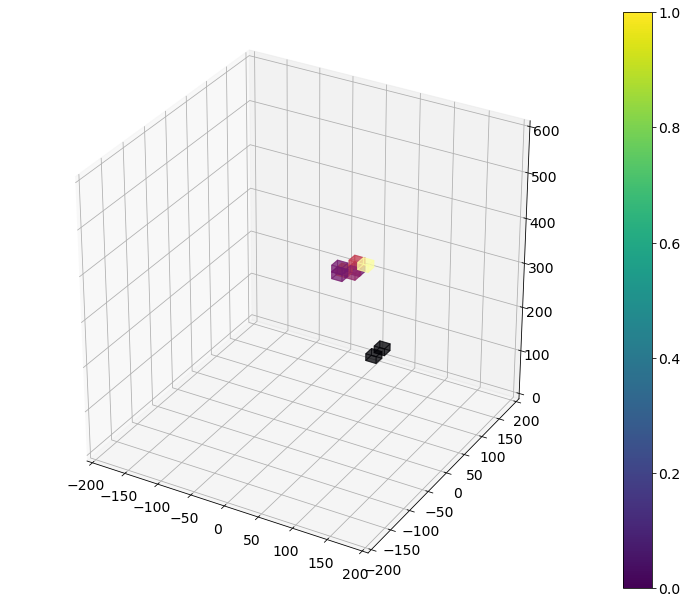

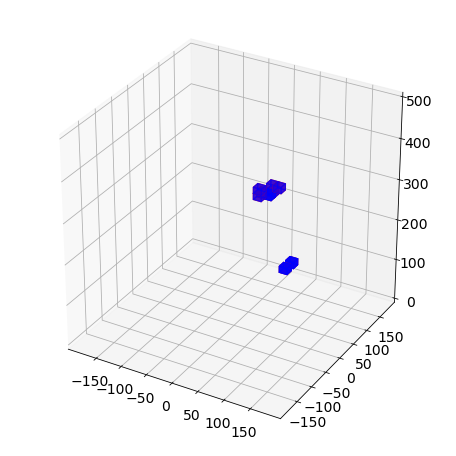

number of tracks found = 3


In [26]:
for event, hitc in hits.items():
    print('----event = {}--- \n'.format(event))
    plot_hits_3D(hitc.hits, xsc=20, ysc=20, zsc=20)
    voxels = paf.voxelize_hits(hitc.hits, vox_size) 
    draw_voxels(voxels, voxel_size, xview=(-200, 200), yview=(-200, 200), zview=(0, 600), 
                alpha=0.5, colormap='inferno')
    tc = paf.make_tracks(1, 1, voxels,
                     vox_size,
                     contiguity   = 1.5,
                     blob_radius  = blob_radius)
    draw_tracks(tc, voxel_size)
    print('number of tracks found = {}'.format(len(tc.tracks)))

In [27]:
for event, hitc in hits.items():
    print(event)

5000000
5000003
5000004
5000007
5000010


In [29]:
list(hits.keys())

[5000000, 5000003, 5000004, 5000007, 5000010]

In [32]:
assert np.equal(list(hits.keys()), [5000000, 5000003, 5000004, 5000007, 5000010]).all()

In [35]:
hit_list = hits[5000000].hits

In [36]:
hit_list

[<Hit : npeak = 0 z = 188.725 E = 25.810489654541016 cluster =< nsipm = 1 Q = 5.687453746795654
                     xy = xy(x=-45.0, y=-55.0) 3dHit = <[-45.0, -55.0, 188.725] 25.810489654541016>  > >,
 <Hit : npeak = 0 z = 189.375 E = 259.1192321777344 cluster =< nsipm = 5 Q = 33.244107723236084
                     xy = xy(x=-38.38036044004566, y=-55.275116821784785) 3dHit = <[-38.38036044004566, -55.275116821784785, 189.375] 259.1192321777344>  > >,
 <Hit : npeak = 0 z = 190.375 E = 1141.244873046875 cluster =< nsipm = 9 Q = 105.87655544281006
                     xy = xy(x=-42.08644796687504, y=-55.5332975168397) 3dHit = <[-42.08644796687504, -55.5332975168397, 190.375] 1141.244873046875>  > >,
 <Hit : npeak = 0 z = 191.375 E = 2838.030550476977 cluster =< nsipm = 9 Q = 245.48413395881653
                     xy = xy(x=-41.80795171232923, y=-56.50490034049296) 3dHit = <[-41.80795171232923, -56.50490034049296, 191.375] 2838.030550476977>  > >,
 <Hit : npeak = 0 z = 191.375 E = 127.3

In [63]:
a = [1,2,3,4]
a.pop(0)

1

In [64]:
a

[2, 3, 4]

In [72]:
Ein = []
Qin = []
Emax = []
Qmax = []
for event, hitc in hits.items():
    E = []
    Q = []
    
    for hit in hitc.hits:
        if(hit.Q != NN):
            E.append(hit.E)
            Q.append(hit.Q)
    print(event, E, Q)
    Emax.append(np.max(E))
    Qmax.append(np.max(Q))
    pop = E.pop(np.argmax(E))
    pop = Q.pop(np.argmax(Q))
    Ein.extend(E)
    Qin.extend(Q)



print('Emax, Qmax')
print(Emax,Qmax)
print()

print('Ein, Qin')
print(Ein,Qin)
print()

print('mean: Emax, Qmax')
print(np.mean(Emax),np.mean(Qmax), np.mean(Emax)/np.mean(Qmax))

print('mean: Ein, Qin')
print(np.mean(Ein),np.mean(Qin), np.mean(Ein)/np.mean(Qin))

r1 = np.mean(Emax)/np.mean(Qmax)
r2 = np.mean(Ein)/np.mean(Qin)
print('r = {}'.format(r1/r2))
r = r1/r2
np.isclose(r, 1, rtol=0.1)

5000000 [25.810489654541016, 259.11923217773438, 1141.244873046875, 2838.0305504769772, 127.34039588901467, 69.674219649632775, 4798.287422810311, 192.88937940258532, 108.48091263085392, 5829.036941452403, 292.15592964134697, 4855.6343814725342, 301.29823571496615, 2818.275390625, 957.92877197265625] [5.6874537467956543, 33.244107723236084, 105.87655544281006, 245.48413395881653, 11.014697074890137, 6.0266847610473633, 371.76678323745728, 14.944887161254883, 8.404998779296875, 320.84376573562622, 16.080942630767822, 211.34004712104797, 13.113916397094727, 95.755774259567261, 19.351255893707275]
5000003 [372.19854736328125, 745.3372802734375, 1095.697265625, 1003.2803344726562, 448.059814453125, 889.57501220703125, 2081.5667002369064, 52.095409138093594, 3468.3922307611815, 146.47349189506829, 3786.861083984375, 2561.9248046875, 1253.7364501953125] [32.34285831451416, 70.812242269515991, 64.36817741394043, 54.849326372146606, 44.725158214569092, 89.107146978378296, 203.09690427780151, 5

True

In [74]:
hits_NN = load_hits_skipping_NN(hits_file_name)

In [76]:
Ein = []
Qin = []
Emax = []
Qmax = []
for event, hitc in hits_NN.items():
    E = []
    Q = []
    
    for hit in hitc.hits:
        #if(hit.Q != NN):
            E.append(hit.E)
            Q.append(hit.Q)
    print(event, E, Q)
    Emax.append(np.max(E))
    Qmax.append(np.max(Q))
    pop = E.pop(np.argmax(E))
    pop = Q.pop(np.argmax(Q))
    Ein.extend(E)
    Qin.extend(Q)



print('Emax, Qmax')
print(Emax,Qmax)
print()

print('Ein, Qin')
print(Ein,Qin)
print()

print('mean: Emax, Qmax')
print(np.mean(Emax),np.mean(Qmax), np.mean(Emax)/np.mean(Qmax))

print('mean: Ein, Qin')
print(np.mean(Ein),np.mean(Qin), np.mean(Ein)/np.mean(Qin))

r1 = np.mean(Emax)/np.mean(Qmax)
r2 = np.mean(Ein)/np.mean(Qin)
print('r = {}'.format(r1/r2))
r = r1/r2
np.isclose(r, 1, rtol=0.1)

5000000 [25.810489654541016, 259.11923217773438, 1141.244873046875, 2838.0305504769772, 127.34039588901467, 69.674219649632775, 4798.287422810311, 192.88937940258532, 108.48091263085392, 5829.036941452403, 292.15592964134697, 4855.6343814725342, 301.29823571496615, 2818.275390625, 957.92877197265625] [5.6874537467956543, 33.244107723236084, 105.87655544281006, 245.48413395881653, 11.014697074890137, 6.0266847610473633, 371.76678323745728, 14.944887161254883, 8.404998779296875, 320.84376573562622, 16.080942630767822, 211.34004712104797, 13.113916397094727, 95.755774259567261, 19.351255893707275]
5000003 [372.19854736328125, 745.3372802734375, 1095.697265625, 1003.2803344726562, 448.059814453125, 889.57501220703125, 2081.5667002369064, 52.095409138093594, 3468.3922307611815, 146.47349189506829, 3786.861083984375, 2561.9248046875, 1253.7364501953125] [32.34285831451416, 70.812242269515991, 64.36817741394043, 54.849326372146606, 44.725158214569092, 89.107146978378296, 203.09690427780151, 5

True

----event = 5000000--- 



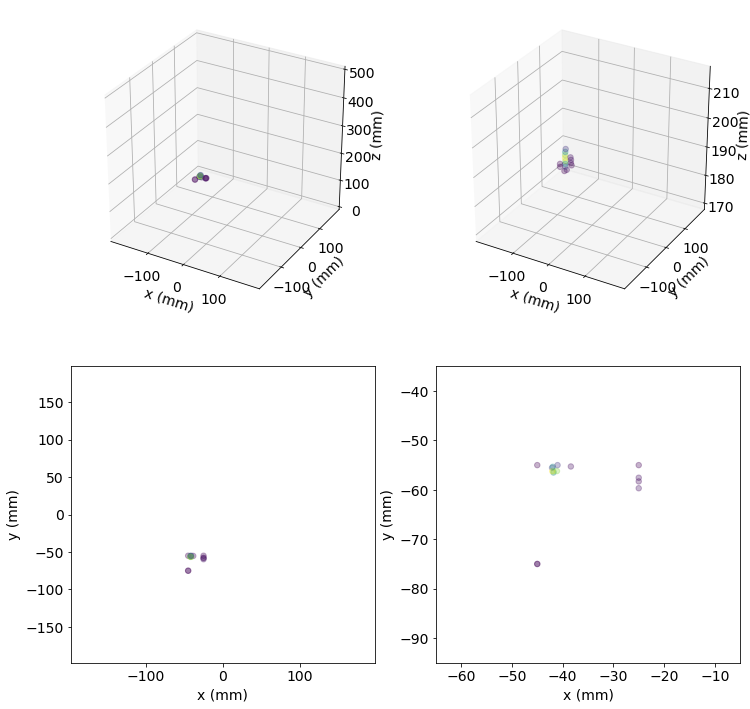

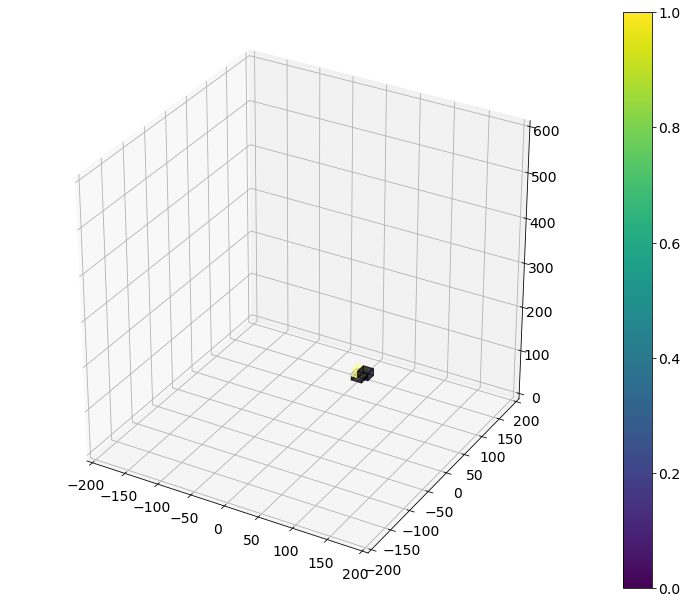

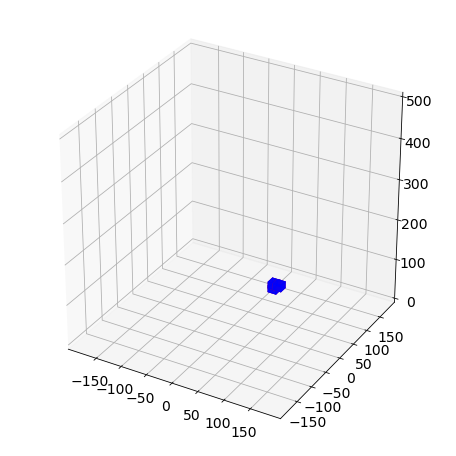

number of tracks found = 1
----event = 5000003--- 



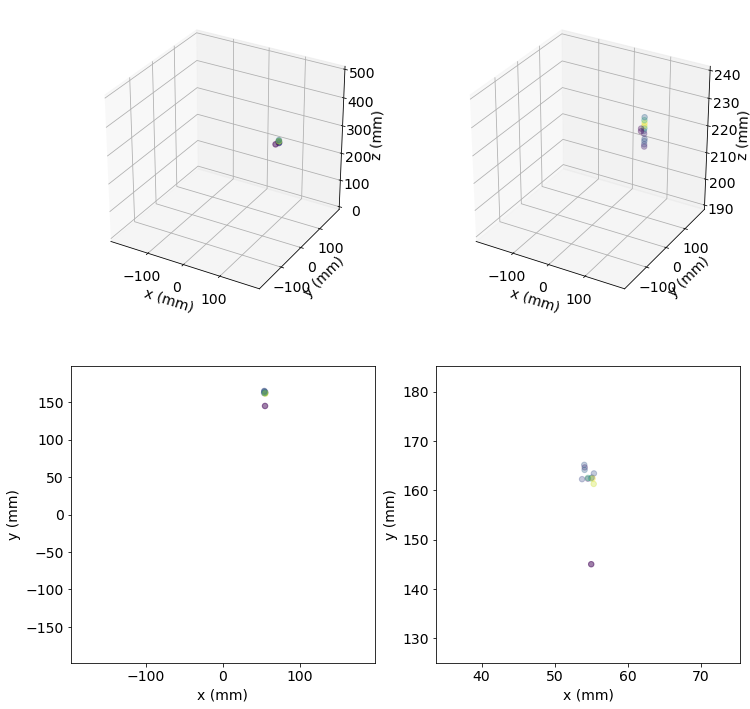

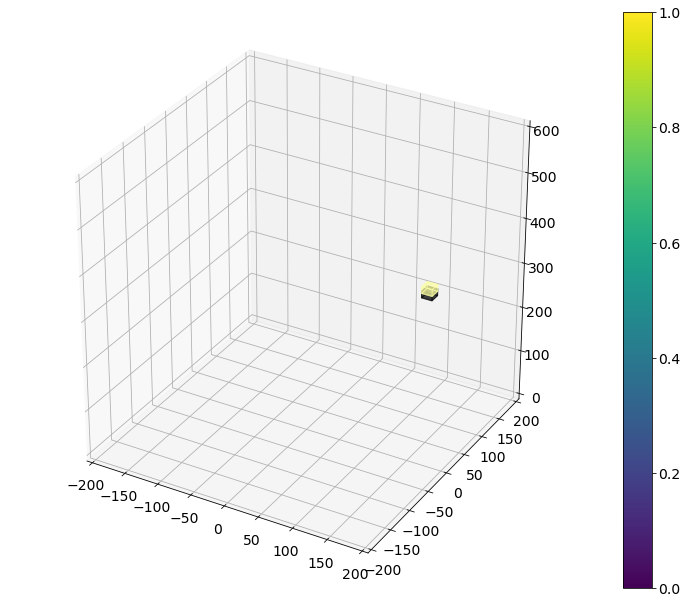

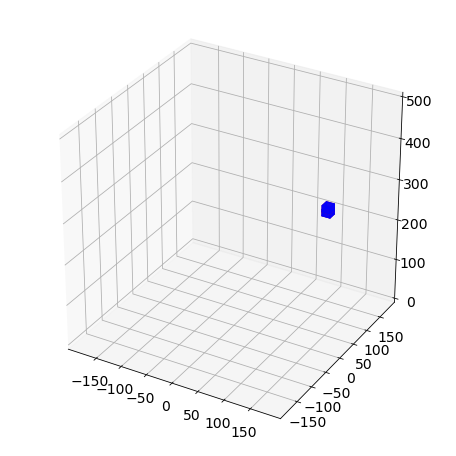

number of tracks found = 1
----event = 5000004--- 



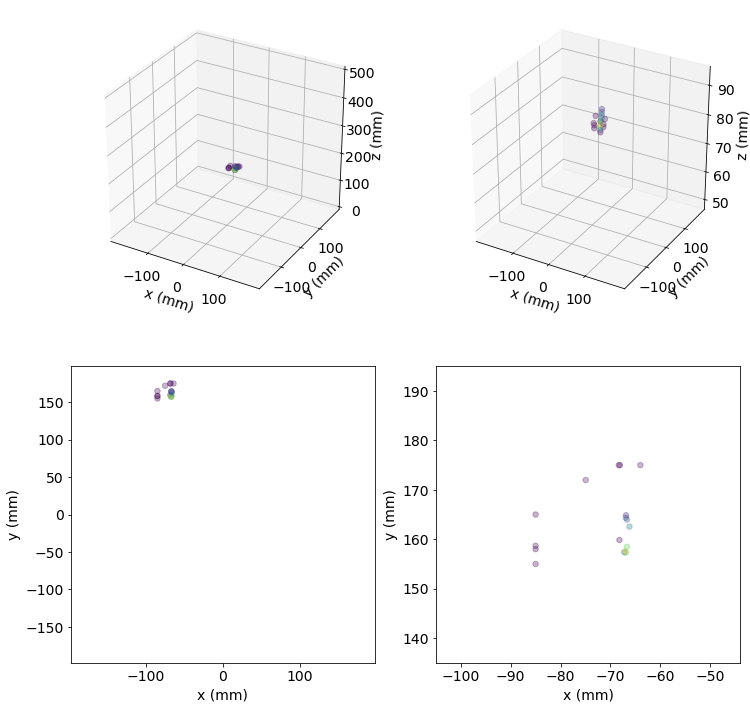

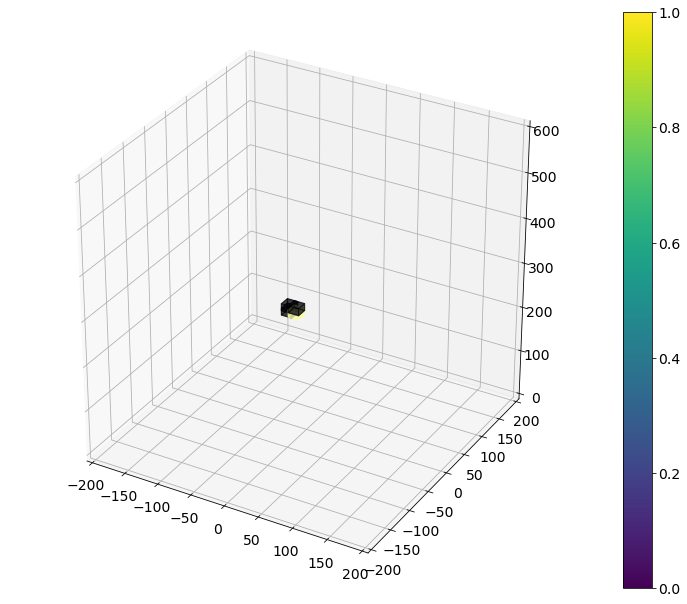

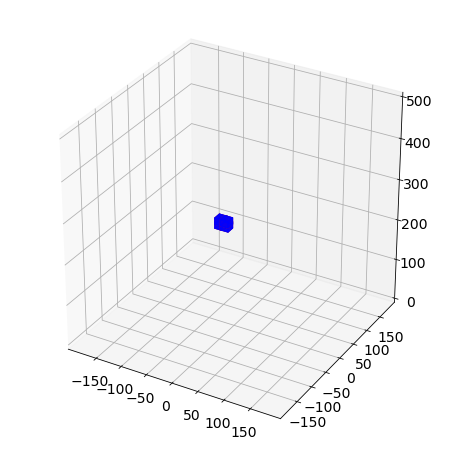

number of tracks found = 1
----event = 5000007--- 



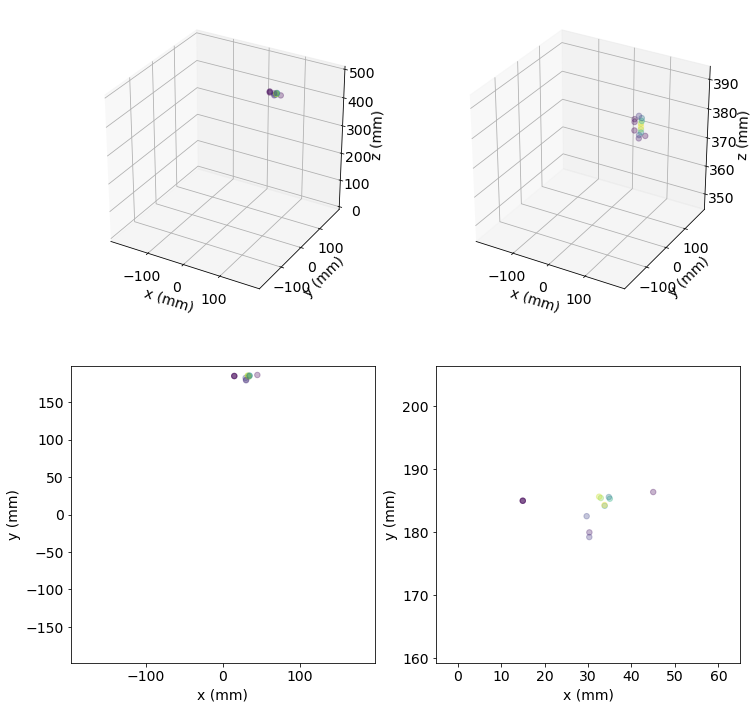

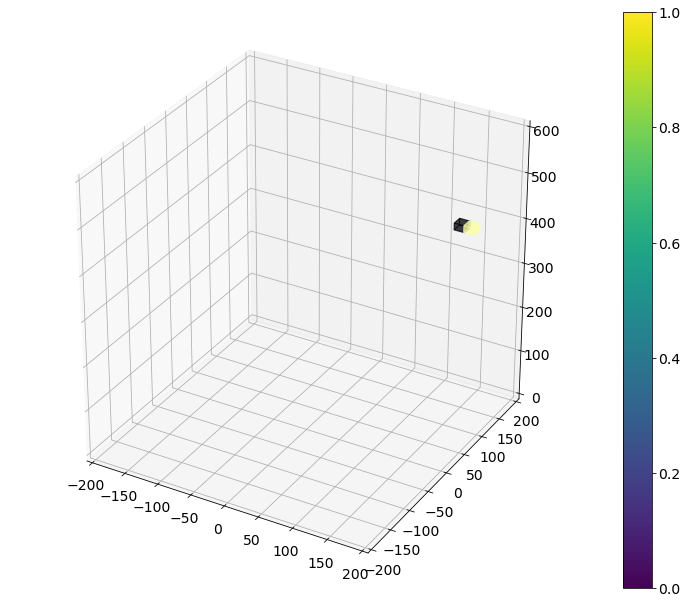

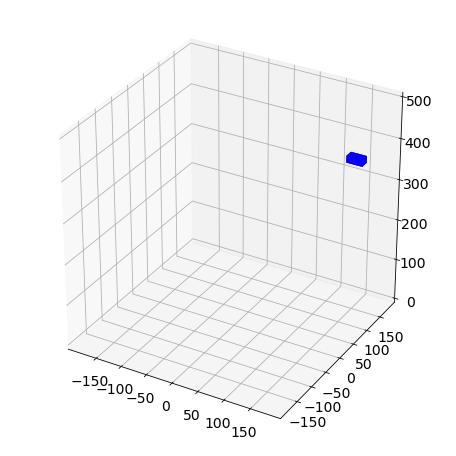

number of tracks found = 1
----event = 5000010--- 



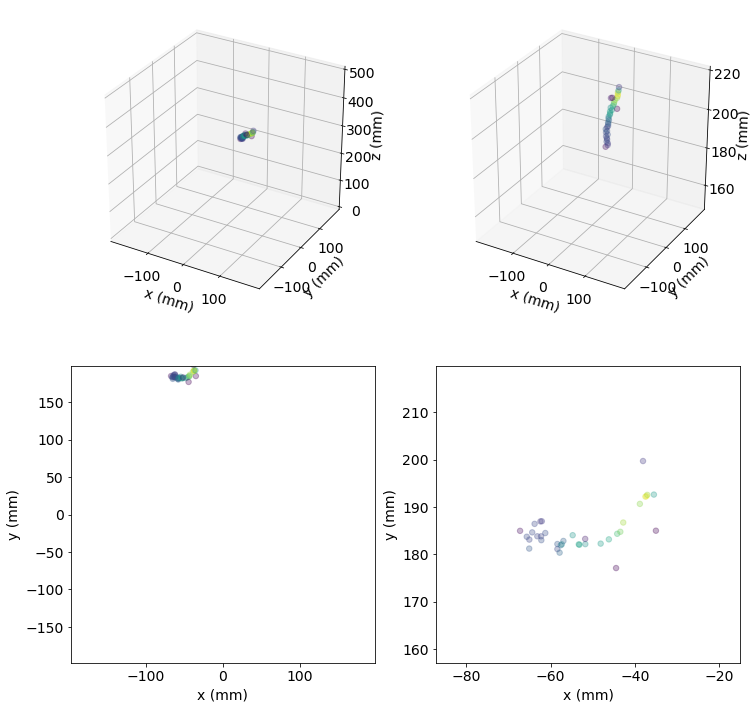

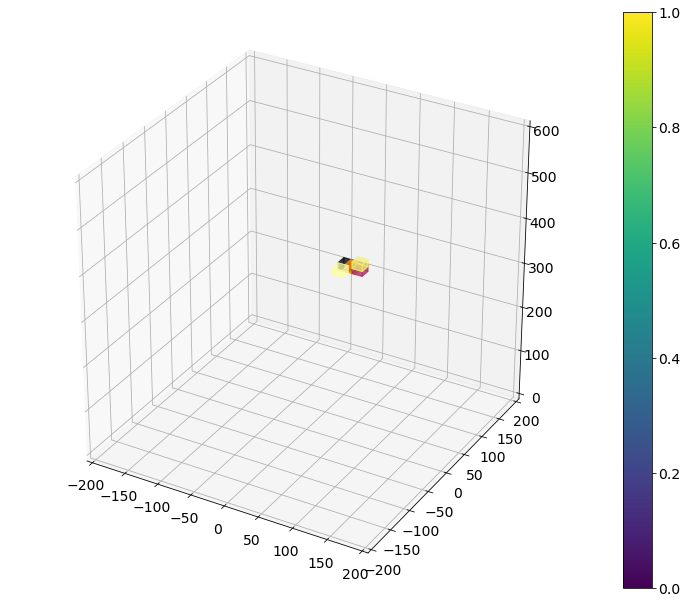

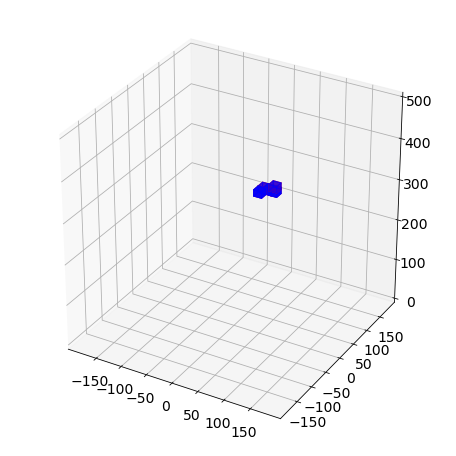

number of tracks found = 2


In [77]:
for event, hitc in hits_NN.items():
    print('----event = {}--- \n'.format(event))
    plot_hits_3D(hitc.hits, xsc=20, ysc=20, zsc=20)
    voxels = paf.voxelize_hits(hitc.hits, vox_size) 
    draw_voxels(voxels, voxel_size, xview=(-200, 200), yview=(-200, 200), zview=(0, 600), 
                alpha=0.5, colormap='inferno')
    tc = paf.make_tracks(1, 1, voxels,
                     vox_size,
                     contiguity   = 1.5,
                     blob_radius  = blob_radius)
    draw_tracks(tc, voxel_size)
    print('number of tracks found = {}'.format(len(tc.tracks)))